# 2.4
- Jag vill se ifall vi predikera ifall någon är positiv för cardiovascular disease.
- I detta fallet använder jag df_2, men jag tror att df_1 hade funkat också
- Efter jag hade kollat runt lite på modeller som ska vara bra på kategorisk data kom jag fram till att jag vill testa:
* KNN
* Random Forest
* SVM
* Logistic Regression

### Recall är viktigare eftersom vi vill inte ha false negatives
### Accuracy är viktigare om vi vill ha mindre false positives

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Code for dfs to be correct

In [28]:
df = pd.read_csv("../Labb/Disease_prediction/cardio_train.csv", sep=";")

df["age"] = round(df["age"]/365).astype(int) 

df['BMI'] = df['weight'] / (df['height']/100)**2

# remove outliers that are below 15 and above 50
df = df[df['BMI'] > 15]
df = df[df['BMI'] < 50]

df['BMI'].min(), df['BMI'].max()

df['BMI_category'] = df['BMI'].apply(lambda x: 1 if x < 25 else 2 if x < 30 else 3)

# removing outliers
# set the limits for systolic blood pressure to 90-200 and for diastolic blood pressure to 60-145
# From what I can find, you have hypotension (low blood pressure) if you go below 90/60.
df = df[df['ap_hi'] > 90]
df = df[df['ap_hi'] < 200] # set it to 200 since the next highest recorded value in the dataset is 197 for systolic blood pressure
# and systolic pressure above 180 is potentially life-threatening, which means not alot of people will have a systolic blood pressure above 200

# diastolic blood pressure limits
# From what I can find, you have hypotension (low blood pressure) if you go below 60 diastolic blood pressure.
df = df[df['ap_lo'] > 60]
df = df[df['ap_lo'] < 145] # set the limit to 145 since the highest recorded value in the dataset is 140 for diastolic blood pressure


df = df[df['ap_hi'] > df['ap_lo']] # removes all rows where the diastolic blood pressure is higher than the systolic blood pressure

for index, row in df.iterrows():
    sys_bp = row['ap_hi']
    dia_bp = row['ap_lo']

    new_col = 'BP_category'

    # Categorize the blood pressure according to the standard guidelines from wikipedia
    if sys_bp < 120 and dia_bp < 80:
        df.at[index, new_col] = 1
    elif sys_bp < 130 and dia_bp < 80:
        df.at[index, new_col] = 2
    elif sys_bp < 140 or dia_bp < 90:
        df.at[index, new_col] = 3
    elif sys_bp < 180 or dia_bp < 120:
        df.at[index, new_col] = 4
    elif sys_bp > 180 or dia_bp > 120:
        df.at[index, new_col] = 5

df_1 = df.drop(['ap_hi', 'ap_lo', 'height', 'weight', 'BMI'], axis=1)
df_2 = df.drop(['height', 'weight', 'BMI_category', 'BP_category'], axis=1)

In [29]:
df_2

,id,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,50,2,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,140,90,3,1,0,0,1,1,34.927679
2,2,52,1,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,150,100,1,1,0,0,1,1,28.710479
5,8,60,1,120,80,2,2,0,0,0,0,29.384676
...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,150,80,1,1,0,0,1,1,29.384757
69995,99993,53,2,120,80,1,1,1,0,1,0,26.927438
69997,99996,52,2,180,90,3,1,0,1,0,1,31.353579
69998,99998,61,1,135,80,1,2,0,0,0,1,27.099251


In [30]:
df_2.drop('id', axis=1, inplace=True) # did not want to keep this column since id is arbitrary and might mess up the model accuracy

In [31]:
from sklearn.model_selection import train_test_split

# splitting the data into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(df_2.drop('cardio', axis=1), df_2['cardio'], test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)


In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# normalizing the features
# normalizer = MinMaxScaler()
# X_train = normalizer.fit_transform(X_train)
# X_val = normalizer.transform(X_val)
# X_test = normalizer.transform(X_test)

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# import suport vector machine
from sklearn.svm import SVC


# hyperparameters for SVM
svm_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}

# hyperparameters for RF
rf_params = {'max_leaf_nodes': [1, 2, 3], 'max_depth': [2, 4, 6], 'min_samples_split': [2, 5, 10]}

# hyperparameters for KNN
k_neigh_params = {'n_neighbors': [1, 2, 5, 10, 15, 20], 'weights': ['uniform', 'distance'], "metric": ['euclidean', 'manhattan', 'minkowski']}

# hyperparameters for LR
log_reg_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# dictionary of hyperparameters for each model
param_grids = {'KNN': k_neigh_params, 'LR': log_reg_params, 'RF': rf_params, 'SVM': svm_params}

# ran the cell two seperate times, don't wanna rerun it again since it takes about 40 minutes to run
# All scores for the hyperparameters are below

In [34]:
models = {"KNN": KNeighborsClassifier(), "LR": LogisticRegression(), "RF": RandomForestClassifier(), "SVM": SVC()}

# performs grid search for each model
for model_name, model in models.items():
    grid = GridSearchCV(model, param_grid=param_grids[model_name], scoring='accuracy', cv=5)
    grid.fit(X_train, y_train)
    print(f"{model_name}: Best Parameters: {grid.best_params_}")
    print(f"{model_name}: Best Score: {grid.best_score_}")


KNN: Best Parameters: {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}
KNN: Best Score: 0.7228435450127343


c:\Users\Danne\.virtualenvs\Machine-learning-PT8MuEHh\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\Danne\.virtualenvs\Machine-learning-PT8MuEHh\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\Danne\.virtualenvs\Machine-learning-PT8MuEHh\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\Danne\.virtualenvs\Machine-learning-PT8MuEHh\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the p

LR: Best Parameters: {'penalty': 'l2', 'solver': 'sag'}
LR: Best Score: 0.7262141095662719


c:\Users\Danne\.virtualenvs\Machine-learning-PT8MuEHh\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Danne\.virtualenvs\Machine-learning-PT8MuEHh\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Danne\.virtualenvs\Machine-learning-PT8MuEHh\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\Danne\.virtualenvs\Machine-learning-PT8MuEHh\lib\site-packages\sklearn\base.py"

RF: Best Parameters: {'max_depth': 2, 'max_leaf_nodes': 3, 'min_samples_split': 10}
RF: Best Score: 0.7189037508917118
SVM: Best Parameters: {'gamma': 'scale', 'kernel': 'rbf'}
SVM: Best Score: 0.7330648011604584


----------------------------------SVM----------------------------------------------------------------
- Best parameters for SVM: "Gamma": "scale", "kernel": "rbf"
- Tested: "Gamma": ["auto", "scale"]
- Tested: "kernel": ['linear', 'poly', 'rbf', 'sigmoid']

-----------------------------------RF--------------------------------------------------------------
- Best parameters for RF: 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100
- Tested: 'n_estimators': [50, 100, 200]
- Tested: 'max_depth': [5, 10, 20, None]
- Tested: 'min_samples_split': [2, 5, 10]

---------------------------------------LR-----------------------------------------------------------
- Best Parameters: {'penalty': 'l2', 'solver': 'liblinear'}
- Tested: 'penalty': ['l1', 'l2', 'elasticnet', 'none']
- Tested: 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

---------------------------------------KNN-----------------------------------------------------------
- KNN: Best Parameters: 'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'
- Tested: k_neigh_params = 'n_neighbors': [1, 2, 5, 10, 15, 20]
- Tested: 'weights': ['uniform', 'distance']
- Tested: "metric": ['euclidean', 'manhattan', 'minkowski']

In [35]:
from sklearn.metrics import accuracy_score

# use best hyperparameters to make predictions on validation data
svm = SVC(C=1, kernel='rbf', gamma='scale')
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_val)

rf = RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=100)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)

lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)

knn = KNeighborsClassifier(n_neighbors=20, weights='uniform', metric='manhattan')
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_val)

# evaluate performance using accuracy
svm_acc = accuracy_score(y_val, svm_preds)
rf_acc = accuracy_score(y_val, rf_preds)
lr_acc = accuracy_score(y_val, lr_preds)
knn_acc = accuracy_score(y_val, knn_preds)

print('SVM Validation Accuracy:', svm_acc)
print('RF Validation Accuracy:', rf_acc)
print('LR Validation Accuracy:', lr_acc)
print('KNN Validation Accuracy:', knn_acc)


SVM Validation Accuracy: 0.7239865209843765
RF Validation Accuracy: 0.7283774124374554
LR Validation Accuracy: 0.7243949760032676
KNN Validation Accuracy: 0.7190850607576841


In [36]:
# calculate test accuracy for SVM
svm_test_preds = svm.predict(X_test)
svm_test_acc = accuracy_score(y_test, svm_test_preds)
print(f'SVM Test Accuracy: {svm_test_acc}')

# calculate test accuracy for RF
rf_test_preds = rf.predict(X_test)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
print(f'RF Test Accuracy: {rf_test_acc}')

# calculate test accuracy for LR
lr_test_preds = lr.predict(X_test)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
print(f'LR Test Accuracy: {lr_test_acc}')

# calculate test accuracy for KNN
knn_test_preds = knn.predict(X_test)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
print(f'KNN Test Accuracy: {knn_test_acc}')

SVM Test Accuracy: 0.72801552446124
RF Test Accuracy: 0.7268920437136145
LR Test Accuracy: 0.7197426207741804
KNN Test Accuracy: 0.7174956592789297


### Testing combining models 

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      4878
           1       0.76      0.66      0.71      4915

    accuracy                           0.73      9793
   macro avg       0.73      0.73      0.72      9793
weighted avg       0.73      0.73      0.72      9793



0.7261309098335545

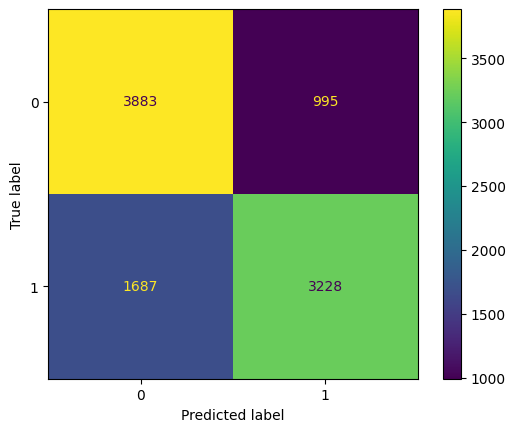

In [37]:
# import votingclassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import VotingClassifier

vote_clf = VotingClassifier(
    [("rf", RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=100)),
     ("svc", SVC(kernel='rbf', gamma='scale')),
        ("knn", KNeighborsClassifier(n_neighbors=20, weights='uniform', metric='manhattan')),
        ("log_reg", LogisticRegression(penalty='l2', solver='liblinear')),
   #   ("naive_complement", ComplementNB()),
   #   ("naive_bernoulli", BernoulliNB()),
   #   ("naive_multinomail", MultinomialNB())
   ], voting="hard")

evaluate_model(vote_clf)

# Worse result than the best individual model for recall
# 0.01 better recall for 0 and 0.01 worse recall for 1 without naive bayes

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      4878
           1       0.76      0.66      0.71      4915

    accuracy                           0.72      9793
   macro avg       0.73      0.72      0.72      9793
weighted avg       0.73      0.72      0.72      9793

0.7239865209843765
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      4878
           1       0.70      0.68      0.69      4915

    accuracy                           0.69      9793
   macro avg       0.69      0.69      0.69      9793
weighted avg       0.69      0.69      0.69      9793

0.6910037782089248


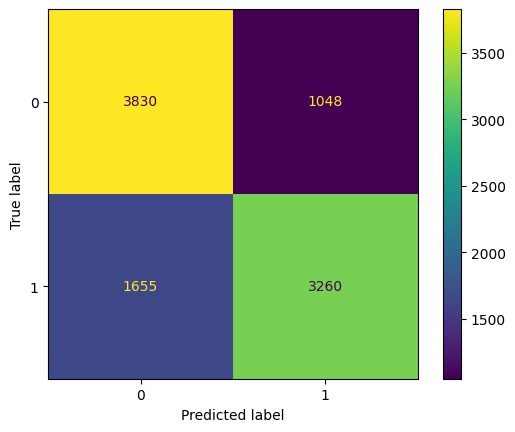

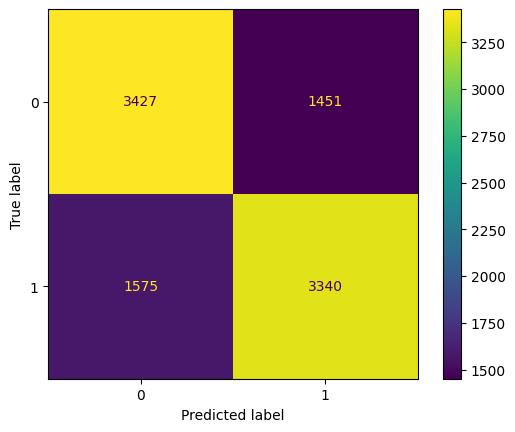

In [38]:
# import confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    print(classification_report(y_val, y_pred))
    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm).plot()

    return accuracy_score(y_val, y_pred)

print(evaluate_model(SVC()))
print(evaluate_model(KNeighborsClassifier()))


              precision    recall  f1-score   support

           0       0.70      0.78      0.74      4878
           1       0.76      0.67      0.71      4915

    accuracy                           0.72      9793
   macro avg       0.73      0.72      0.72      9793
weighted avg       0.73      0.72      0.72      9793

0.7243949760032676
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      4878
           1       0.68      0.69      0.69      4915

    accuracy                           0.68      9793
   macro avg       0.68      0.68      0.68      9793
weighted avg       0.68      0.68      0.68      9793

0.6831410190952721


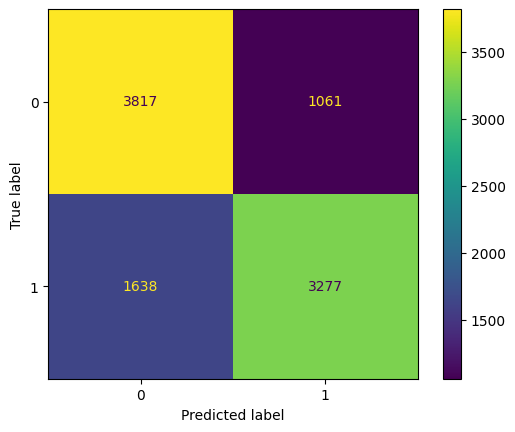

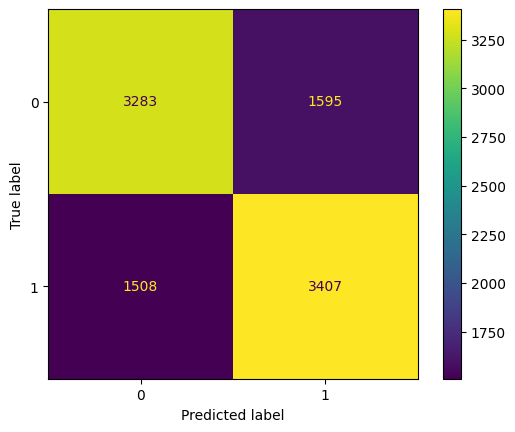

In [39]:
print(evaluate_model(LogisticRegression()))
print(evaluate_model(RandomForestClassifier()))